In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm 

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/data and weights/sensor_final.csv')

In [ ]:
df.shape

(119103, 24)

In [ ]:
df.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
0,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834
1,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834
2,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,...,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963
3,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,...,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028
4,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,...,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093


In [ ]:
df.columns

Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49'],
      dtype='object')

In [ ]:
n_in = 11   #keep this odd

n_out = 5

val_size = 10

test_size = 5

In [ ]:
def lstm_train_data_transform(df, n_in, n_out,val_size,test_size):
    
  """ Changes data to the format for LSTM training 
        for sliding window approach """    
    
  encoder_input, decoder_input, final_output = list(), list(), list()         # Prepare the list for the transformed data
    
  for i in range(df.shape[0]):          # Loop of the entire data set          
    
    total_steps = i + n_in + n_out

    if total_steps >= df.shape[0]:   # if index is larger than the size of the dataset, we stop
      
      break   
      
    end_enc_inp = i + n_in                       # compute a new (sliding window) index for encoder input
                
    end_dec_inp = end_enc_inp + n_out - 1                     # compute a new (sliding window) index for input steps
        
    final_out_end = end_enc_inp + n_out
        
    seq_enc_input = df[i:end_enc_inp]                    # Get a sequence of data for x
        
    seq_dec_input = df[end_enc_inp:end_dec_inp]               # Get a sequence of data for x
        
    seq_final_out = df[end_enc_inp:final_out_end]
        
    encoder_input.append(seq_enc_input)                             # Append the list with sequencies
        
    decoder_input.append(seq_dec_input)    
        
    final_output.append(seq_final_out)
    
  encoder_input = np.array(encoder_input)                           # Make final arrays
    
  decoder_input = np.array(decoder_input)
    
  final_output = np.array(final_output)
        
  train_size = round(( encoder_input.shape[0] * (val_size + test_size) ) / 100)
        
  train_size = encoder_input.shape[0] - train_size
    
  val_size = round((encoder_input.shape[0] * val_size) / 100)
    
  val_size = train_size + val_size
        
  encoder_input_train = encoder_input[:train_size]
    
  decoder_input_train = decoder_input[:train_size]
    
  final_output_train = final_output[:train_size]
    
  encoder_input_val = encoder_input[train_size:val_size]
    
  decoder_input_val = decoder_input[train_size:val_size]
    
  final_output_val = final_output[train_size:val_size]
    
  encoder_input_test = encoder_input[val_size:]
    
  decoder_input_test = decoder_input[val_size:]
    
  final_output_test = final_output[val_size:]
    
  return encoder_input_train, decoder_input_train, final_output_train, encoder_input_val, decoder_input_val, final_output_val, encoder_input_test, decoder_input_test, final_output_test

In [ ]:
encoder_input_train, decoder_input_train, final_output_train, encoder_input_val, decoder_input_val, final_output_val, encoder_input_test, decoder_input_test, final_output_test = lstm_train_data_transform(df,n_in,n_out,val_size,test_size)

In [ ]:
print(encoder_input_train.shape, decoder_input_train.shape, final_output_train.shape, encoder_input_val.shape, decoder_input_val.shape, final_output_val.shape, encoder_input_test.shape, decoder_input_test.shape, final_output_test.shape)

(101224, 11, 24) (101224, 4, 24) (101224, 5, 24) (11909, 11, 24) (11909, 4, 24) (11909, 5, 24) (5954, 11, 24) (5954, 4, 24) (5954, 5, 24)


In [ ]:
encoder_input_train[0]

array([[ 47.09201   ,  53.2118    ,  46.31076   , 634.375     ,
         76.45975   ,  13.41146   ,  16.13136   ,  15.56713   ,
         15.05353   ,  37.2274    ,  47.52422   ,  31.11716   ,
          1.681353  ,  31.51042   ,  70.57291   ,  30.98958   ,
         31.77083206,  41.92708   ,  39.6412    ,  65.68287   ,
         50.92593   ,  38.19444   , 157.9861    ,  67.70834   ],
       [ 47.09201   ,  53.2118    ,  46.31076   , 634.375     ,
         76.45975   ,  13.41146   ,  16.13136   ,  15.56713   ,
         15.05353   ,  37.2274    ,  47.52422   ,  31.11716   ,
          1.681353  ,  31.51042   ,  70.57291   ,  30.98958   ,
         31.77083206,  41.92708   ,  39.6412    ,  65.68287   ,
         50.92593   ,  38.19444   , 157.9861    ,  67.70834   ],
       [ 47.35243   ,  53.2118    ,  46.39757   , 638.8889    ,
         73.54598   ,  13.32465   ,  16.03733   ,  15.61777   ,
         15.01013   ,  37.86777   ,  48.17723   ,  32.08894   ,
          1.708474  ,  31.25      ,  6

In [ ]:
decoder_input_train[0]

array([[ 47.91666   ,  53.1684    ,  46.39756775, 635.6482    ,
         74.58654   ,  13.41146   ,  16.16753   ,  15.84925   ,
         15.11863   ,  39.78521   ,  50.7882    ,  33.14559   ,
          1.62582   ,  32.29166   ,  78.125     ,  30.46875   ,
         31.51041603,  41.66666   ,  39.35185242,  53.81944   ,
         51.21528   ,  39.0625    , 193.5764    ,  72.33796   ],
       [ 48.26389   ,  53.125     ,  46.39756775, 630.0926    ,
         76.95988   ,  13.34635   ,  16.16753   ,  15.73351   ,
         15.01013   ,  40.04284   ,  50.50479   ,  33.46326   ,
          1.641763  ,  31.77083   ,  78.64583   ,  30.46874809,
         31.51041603,  42.70833   ,  39.35185   ,  53.24074   ,
         50.92593   ,  39.0625    , 195.6019    ,  72.33796   ],
       [ 48.4375    ,  53.1684    ,  46.39756775, 638.6574    ,
         75.6731    ,  13.31742   ,  16.16753   ,  15.84925   ,
         15.16927   ,  40.90296   ,  50.96519   ,  33.63691   ,
          1.67578   ,  30.98958   ,  7

In [ ]:
final_output_train[0]

array([[ 47.91666   ,  53.1684    ,  46.39756775, 635.6482    ,
         74.58654   ,  13.41146   ,  16.16753   ,  15.84925   ,
         15.11863   ,  39.78521   ,  50.7882    ,  33.14559   ,
          1.62582   ,  32.29166   ,  78.125     ,  30.46875   ,
         31.51041603,  41.66666   ,  39.35185242,  53.81944   ,
         51.21528   ,  39.0625    , 193.5764    ,  72.33796   ],
       [ 48.26389   ,  53.125     ,  46.39756775, 630.0926    ,
         76.95988   ,  13.34635   ,  16.16753   ,  15.73351   ,
         15.01013   ,  40.04284   ,  50.50479   ,  33.46326   ,
          1.641763  ,  31.77083   ,  78.64583   ,  30.46874809,
         31.51041603,  42.70833   ,  39.35185   ,  53.24074   ,
         50.92593   ,  39.0625    , 195.6019    ,  72.33796   ],
       [ 48.4375    ,  53.1684    ,  46.39756775, 638.6574    ,
         75.6731    ,  13.31742   ,  16.16753   ,  15.84925   ,
         15.16927   ,  40.90296   ,  50.96519   ,  33.63691   ,
          1.67578   ,  30.98958   ,  7

SCALING

In [ ]:
historical_max = np.expand_dims(np.max(encoder_input_train.reshape(-1, encoder_input_train.shape[-1]),axis=0,keepdims=True),0)

In [ ]:
historical_max

array([[[ 55.77257,  56.03299,  48.22049, 671.9907 ,  99.98649,
          21.39034,  23.50984,  19.29253,  18.98871,  76.10686,
          60.     ,  45.     ,  31.18755, 547.9166 , 512.7604 ,
         219.0104 , 330.4688 , 302.0833 , 221.0648 , 220.1968 ,
         320.8912 , 196.7593 , 474.8264 , 241.3194 ]]])

In [ ]:
historical_min = np.expand_dims(np.min(encoder_input_train.reshape(-1, encoder_input_train.shape[-1]),axis=0,keepdims=True),0)

In [ ]:
historical_min

array([[[2.24392400e+01, 3.73263900e+01, 3.32899300e+01, 3.10474500e+00,
         0.00000000e+00, 1.44675900e-02, 0.00000000e+00, 2.89351800e-02,
         7.23379600e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.31770800e+01, 3.02083300e+01, 2.39583300e+01,
         2.57812500e+01, 2.89062500e+01, 2.86458300e+01, 2.89351800e+01,
         3.06712971e+01, 3.09606476e+01, 3.03819400e+01, 3.00925900e+01]]])

In [ ]:
scaler = StandardScaler()

encoder_input_train = scaler.fit_transform(encoder_input_train.reshape(-1, encoder_input_train.shape[-1])).reshape(encoder_input_train.shape)

decoder_input_train = scaler.transform(decoder_input_train.reshape(-1, decoder_input_train.shape[-1])).reshape(decoder_input_train.shape)

final_output_train = scaler.transform(final_output_train.reshape(-1, final_output_train.shape[-1])).reshape(final_output_train.shape)

encoder_input_val = scaler.transform(encoder_input_val.reshape(-1, encoder_input_val.shape[-1])).reshape(encoder_input_val.shape)

decoder_input_val = scaler.transform(decoder_input_val.reshape(-1, decoder_input_val.shape[-1])).reshape(decoder_input_val.shape)

final_output_val = scaler.transform(final_output_val.reshape(-1, final_output_val.shape[-1])).reshape(final_output_val.shape)

In [ ]:
encoder_input_train[0]

array([[-0.54631168,  0.5727396 ,  1.36906545,  0.21392662,  0.07214835,
         0.10998497,  0.20147029,  0.41477671,  0.12168122, -0.67438464,
         0.67621107,  0.17247491, -0.45945301, -0.42285224,  0.25460254,
        -0.661152  , -0.50195479, -0.18998675, -0.15558952,  2.30416724,
         0.45440307, -0.6325951 ,  0.61345869,  1.00941656],
       [-0.54631168,  0.5727396 ,  1.36906545,  0.21392662,  0.07214835,
         0.10998497,  0.20147029,  0.41477671,  0.12168122, -0.67438464,
         0.67621107,  0.17247491, -0.45945301, -0.42285224,  0.25460254,
        -0.661152  , -0.50195479, -0.18998675, -0.15558952,  2.30416724,
         0.45440307, -0.6325951 ,  0.61345869,  1.00941656],
       [-0.412428  ,  0.5727396 ,  1.41752268,  0.28344326, -0.16908482,
         0.01072552,  0.07735467,  0.4893059 ,  0.05795712, -0.59307624,
         0.75323659,  0.29620119, -0.45280142, -0.44192184,  0.19557475,
        -0.72455235, -0.50195503, -0.21836529, -0.19635725,  2.27540009,
  

In [ ]:
decoder_input_train[0]

array([[-0.12235356,  0.55105315,  1.41752142,  0.23353463, -0.08293609,
         0.10998497,  0.24921316,  0.8299855 ,  0.21726737, -0.34961701,
         1.06121243,  0.43073306, -0.47307281, -0.36564492,  0.68255709,
        -0.72455235, -0.53239086, -0.21836529, -0.19635725,  1.12470636,
         0.47889862, -0.52751881,  1.23437391,  1.36759668],
       [ 0.05615971,  0.5293667 ,  1.41752142,  0.14797522,  0.11355449,
         0.03553753,  0.24921316,  0.6596457 ,  0.05795712, -0.31690548,
         1.02778292,  0.47117857, -0.4691627 , -0.40378338,  0.71207098,
        -0.72455258, -0.53239086, -0.10485222, -0.19635759,  1.06717207,
         0.45440307, -0.52751881,  1.26971117,  1.36759668],
       [ 0.14541378,  0.55105315,  1.41752142,  0.27987802,  0.00702102,
         0.00245867,  0.24921316,  0.8299855 ,  0.29162194, -0.20769521,
         1.08208921,  0.49328755, -0.46081982, -0.46099144,  0.62352874,
        -0.72455258, -0.53239086, -0.10485222, -0.0332839 ,  1.12470636,
  

In [ ]:
final_output_train[0]

array([[-0.12235356,  0.55105315,  1.41752142,  0.23353463, -0.08293609,
         0.10998497,  0.24921316,  0.8299855 ,  0.21726737, -0.34961701,
         1.06121243,  0.43073306, -0.47307281, -0.36564492,  0.68255709,
        -0.72455235, -0.53239086, -0.21836529, -0.19635725,  1.12470636,
         0.47889862, -0.52751881,  1.23437391,  1.36759668],
       [ 0.05615971,  0.5293667 ,  1.41752142,  0.14797522,  0.11355449,
         0.03553753,  0.24921316,  0.6596457 ,  0.05795712, -0.31690548,
         1.02778292,  0.47117857, -0.4691627 , -0.40378338,  0.71207098,
        -0.72455258, -0.53239086, -0.10485222, -0.19635759,  1.06717207,
         0.45440307, -0.52751881,  1.26971117,  1.36759668],
       [ 0.14541378,  0.55105315,  1.41752142,  0.27987802,  0.00702102,
         0.00245867,  0.24921316,  0.8299855 ,  0.29162194, -0.20769521,
         1.08208921,  0.49328755, -0.46081982, -0.46099144,  0.62352874,
        -0.72455258, -0.53239086, -0.10485222, -0.0332839 ,  1.12470636,
  

CHECKPOINTS

In [ ]:
#callbacks

filepath = '/content/drive/My Drive/data and weights/option_2/separate_tf'

filepath = filepath + "/weights-{epoch:02d}.hdf5"

checkpoint_cb = ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

lr_cb = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001,verbose=1)

es_cp = EarlyStopping(monitor='val_loss', patience=5)

cb = [checkpoint_cb, lr_cb, es_cp]

MODELLING

In [ ]:
batch_size = 64  # Batch size for training.

epochs = 100  # Number of epochs to train for.

units = 256  # no of lstm units

features = 24

In [ ]:
#teacher forcing
# Define an input sequence and process it.

class MyModel(Model):
  
  def __init__(self, encoder_inputs_length,decoder_outputs_length, features, units):
    
    super().__init__()

    self.decoder_outputs_length = decoder_outputs_length
    self.features = features

    var = []
    
    for i in range(features):
      
      lst = []

      encoder = LSTM(units, return_state=True, dtype='float64')
      decoder = LSTM(units, return_sequences=True, return_state=True, dtype='float64')
      dense   = Dense(1, dtype='float64')
    
      lst.append(encoder)
      lst.append(decoder)
      lst.append(dense)
      var.append(lst)

    self.var = var
        
  def call(self, data):
    
    encoder_input,decoder_input = data[0], data[1]

    all_outputs = []

    for i in range(self.features):
      
      outputs = []
            
      enc_input,d_input = tf.expand_dims(encoder_input[:,:,i],2), tf.expand_dims(decoder_input[:,:,i],2)

      e_input = enc_input[:,:-1,:]
      
      _, hidden, cell = self.var[i][0](e_input) # We discard `encoder_outputs` and only keep the states.

      states = [hidden, cell]
                
      cur_vec = tf.expand_dims(enc_input[:,-1,:],1)
                              
      final, hidden, cell = self.var[i][1](cur_vec, initial_state=states)     
      
      final = self.var[i][2](final)
                  
      outputs.append(final)
      
      states = [hidden, cell]

      for j in range(self.decoder_outputs_length-1):
        
        cur_vec = tf.expand_dims(d_input[:,j,:],1) 
            
        final, hidden, cell = self.var[i][1](cur_vec, initial_state=states)
                  
        final = self.var[i][2](final)
                  
        outputs.append(final)
      
        states = [hidden, cell]
            
      outputs = tf.concat(outputs,axis=1)
    
      all_outputs.append(outputs)

    all_outputs = tf.concat(all_outputs,axis=2)
      
    return all_outputs           

In [ ]:
model  = MyModel(n_in, n_out, features , units)

model.compile(optimizer='adam', loss='mse')

In [ ]:
#teacher forcing
model.build(input_shape=[(None,n_in , features),(None,n_out - 1 , features)])

model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  264192    
                                                                 
 lstm_1 (LSTM)               multiple                  264192    
                                                                 
 dense (Dense)               multiple                  257       
                                                                 
 lstm_2 (LSTM)               multiple                  264192    
                                                                 
 lstm_3 (LSTM)               multiple                  264192    
                                                                 
 dense_1 (Dense)             multiple                  257       
                                                                 
 lstm_4 (LSTM)               multiple                  264

In [ ]:
#teacher forcing
model.fit(
    [encoder_input_train, decoder_input_train],
    final_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_val,decoder_input_val],final_output_val),
    callbacks=cb
)

Epoch 1/100
1582/1582 [==============================] - ETA: 0s - loss: 0.0295
Epoch 1: val_loss improved from inf to 1.12908, saving model to /content/drive/My Drive/data and weights/option_2/separate_tf/weights-01.hdf5
1582/1582 [==============================] - 1123s 583ms/step - loss: 0.0295 - val_loss: 1.1291 - lr: 0.0010
Epoch 2/100
1582/1582 [==============================] - ETA: 0s - loss: 0.0172
Epoch 2: val_loss improved from 1.12908 to 1.00137, saving model to /content/drive/My Drive/data and weights/option_2/separate_tf/weights-02.hdf5
1582/1582 [==============================] - 875s 553ms/step - loss: 0.0172 - val_loss: 1.0014 - lr: 0.0010
Epoch 3/100
1582/1582 [==============================] - ETA: 0s - loss: 0.0166
Epoch 3: val_loss did not improve from 1.00137
1582/1582 [==============================] - 874s 553ms/step - loss: 0.0166 - val_loss: 1.2231 - lr: 0.0010
Epoch 4/100
1582/1582 [==============================] - ETA: 0s - loss: 0.0162
Epoch 4: val_loss di

INFERENCE

In [ ]:
def inference(input):
  
  input = scaler.transform(input)
        
  input = tf.expand_dims(input,0)
    
  encoder_input = input

  all_outputs = []

  layers = [model_new.layers[i: i+3] for i in range(0, len(model_new.layers), 3)]
    
  for i in range(features):
    
    outputs = []
            
    enc_input = tf.expand_dims(encoder_input[:,:,i],2)

    e_input = enc_input[:,:-1,:]
            
    _, hidden, cell = layers[i][0](e_input) # We discard `encoder_outputs` and only keep the states.

    states = [hidden, cell]
                      
    cur_vec = tf.expand_dims(enc_input[:,-1,:],1)
                                   
    final, hidden, cell = layers[i][1](cur_vec, initial_state=states)     
            
    final = layers[i][2](final)
                        
    outputs.append(final)
            
    states = [hidden, cell]

    for j in range(n_out-1):
      
      cur_vec = final
            
      final, hidden, cell = layers[i][1](cur_vec, initial_state=states)
                        
      final = layers[i][2](final)
                        
      outputs.append(final)
            
      states = [hidden, cell]
            
    outputs = tf.concat(outputs,axis=1)
          
    all_outputs.append(outputs)

  all_outputs = np.concatenate(all_outputs,axis=2)
            
  all_outputs = scaler.inverse_transform(all_outputs.reshape(-1, all_outputs.shape[-1])).reshape(all_outputs.shape)
    
  for i in range(all_outputs.shape[1]):
    
    for j in range(all_outputs.shape[2]):
      
      if all_outputs[:,i,j] < historical_min[0][0][j]:
        
        all_outputs[:,i,j] = historical_min[0][0][j]
            
      elif all_outputs[:,i,j] > historical_max[0][0][j]:
            
        all_outputs[:,i,j] = historical_max[0][0][j]
    
  return all_outputs  

PERFORMANCE ON UNSEEN DATA

TEACHER FORCING

In [ ]:
## loading saved weights
#teacher forcing

model_new = MyModel(n_in, n_out, features , units)

model_new.build(input_shape=[(None,n_in , features),(None,n_out - 1 , features)])

model_new.load_weights(r'/content/drive/My Drive/data and weights/option_2/separate_tf/weights-02.hdf5')

In [ ]:
model_new

In [ ]:
model_new.layers

In [ ]:
eg_in = encoder_input_test[-100].copy()   #random input

eg_in

array([[ 45.22569275,  51.3888855 ,  46.7013855 , 623.3796    ,
         96.39205   ,  13.79485   ,  16.16753   ,  15.29224   ,
         15.05353   ,  49.47406   ,  43.70945   ,  30.50584   ,
          0.8548685 ,  44.53125   ,  65.625     ,  44.01041   ,
         37.5       ,  40.88541   ,  37.90509   ,  37.61574173,
         40.50926   ,  44.56018   , 130.4977    ,  46.00694   ],
       [ 45.22569275,  51.3888855 ,  46.7013855 , 632.2916    ,
         96.22805   ,  13.64294   ,  16.21094   ,  15.03906   ,
         15.11863   ,  50.95663   ,  43.37484   ,  30.55821   ,
          0.8667177 ,  45.57291   ,  65.36458   ,  49.47916   ,
         38.02083   ,  41.66666   ,  37.90509415,  37.61574173,
         40.79861   ,  46.2963    , 127.8935    ,  46.2963    ],
       [ 45.22569275,  51.3888855 ,  46.7013855 , 632.2916    ,
         96.22805   ,  13.64294   ,  16.21094   ,  15.03906   ,
         15.11863   ,  50.95663   ,  43.37484   ,  30.55821   ,
          0.8667177 ,  45.57291   ,  6

In [ ]:
eg_out = final_output_test[-100].copy()

eg_out

array([[ 45.22569   ,  51.43228912,  46.70139   , 628.0093    ,
         92.19081   ,  13.67911   ,  16.23987   ,  15.14757   ,
         15.01013   ,  44.71954   ,  42.8599    ,  32.43655   ,
          0.8187066 ,  44.27083   ,  51.04166   ,  47.13541   ,
         37.5       ,  38.80208   ,  46.2963    ,  37.90509415,
         43.98148   ,  56.42361069, 114.5833    ,  46.875     ],
       [ 45.13889   ,  51.43228912,  46.7013855 , 634.2593    ,
         95.17554   ,  13.71528   ,  16.2037    ,  15.22714   ,
         14.97396   ,  44.0352    ,  46.24181   ,  32.91639   ,
          0.8655689 ,  45.57291   ,  51.30208   ,  44.53125   ,
         36.97916   ,  38.28125   ,  44.56018448,  37.90509   ,
         43.40277863,  52.66204   , 116.8981    ,  47.74306   ],
       [ 45.13889   ,  51.43228912,  46.7013855 , 634.2593    ,
         95.17554   ,  13.71528   ,  16.2037    ,  15.22714   ,
         14.97396   ,  44.0352    ,  46.24181   ,  32.91639   ,
          0.8655689 ,  45.57291   ,  5

In [ ]:
pred_out = inference(eg_in)

pred_out

array([[[4.51093472e+01, 5.14414577e+01, 4.66973899e+01, 6.29310925e+02,
         9.28315319e+01, 1.35753499e+01, 1.61919119e+01, 1.51814583e+01,
         1.50654281e+01, 4.51287375e+01, 4.13480838e+01, 3.18826777e+01,
         8.11465038e-01, 4.41544316e+01, 5.20434217e+01, 4.72329137e+01,
         3.77234876e+01, 3.90554028e+01, 4.74782606e+01, 3.80576106e+01,
         4.44330494e+01, 5.70684352e+01, 1.11797180e+02, 4.67303872e+01],
        [4.50630979e+01, 5.14441422e+01, 4.66842097e+01, 6.31518437e+02,
         9.25868377e+01, 1.35711416e+01, 1.61891228e+01, 1.52128364e+01,
         1.50721933e+01, 4.49980338e+01, 4.11948478e+01, 3.18241001e+01,
         7.53329712e-01, 4.38306232e+01, 5.27776935e+01, 4.61381480e+01,
         3.76246500e+01, 3.91835829e+01, 4.77419618e+01, 3.83644111e+01,
         4.43416850e+01, 5.59752408e+01, 1.09813169e+02, 4.68171869e+01],
        [4.50342129e+01, 5.14448673e+01, 4.66762041e+01, 6.31478038e+02,
         9.23750526e+01, 1.35657316e+01, 1.618471

In [ ]:
mean_squared_error(eg_out, pred_out.reshape(-1,pred_out.shape[-1]),squared=False)

1.6380164219802094

In [ ]:
pred = []

for i in tqdm(range(encoder_input_test.shape[0])):
    
    x = encoder_input_test[i].copy()
        
    x = inference(x)
    
    pred.append(x)
    
pred = np.concatenate(pred,0)

100%|██████████| 5954/5954 [1:23:38<00:00,  1.19it/s]


In [ ]:
pred.shape

(5954, 5, 24)

Total rmse

In [ ]:
mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1]), pred.reshape(-1,pred.shape[-1]),squared=False)

2.655160812317782

Total rmse f1

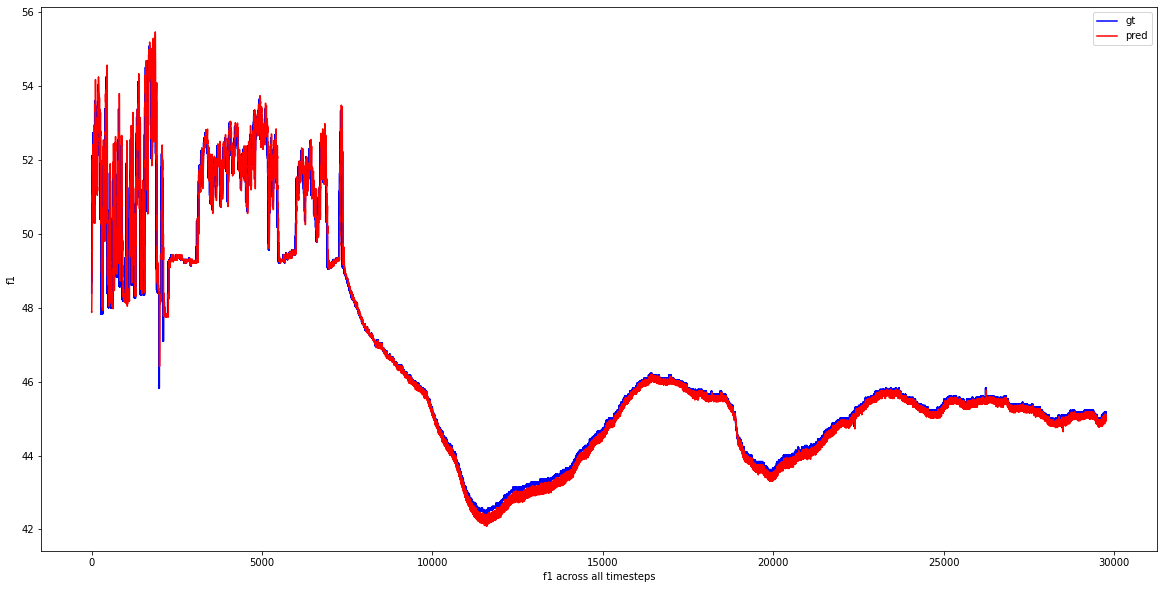

0.46762451098970614


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,0], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,0],c='red', label="pred")

plt.legend()

plt.xlabel('f1 across all timesteps')

plt.ylabel('f1')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,0], pred.reshape(-1,pred.shape[-1])[:,0],squared=False))

Total rmse f2

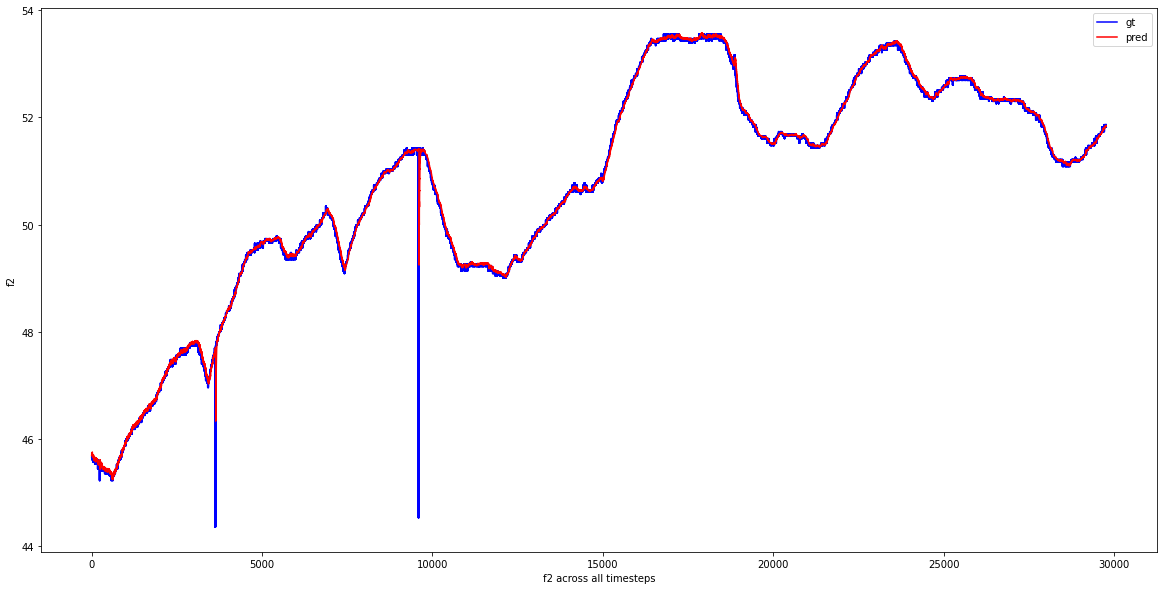

0.11832612995356834


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,1], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,1],c='red', label="pred")

plt.legend()

plt.xlabel('f2 across all timesteps')

plt.ylabel('f2')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,1], pred.reshape(-1,pred.shape[-1])[:,1],squared=False))

Total rmse f3

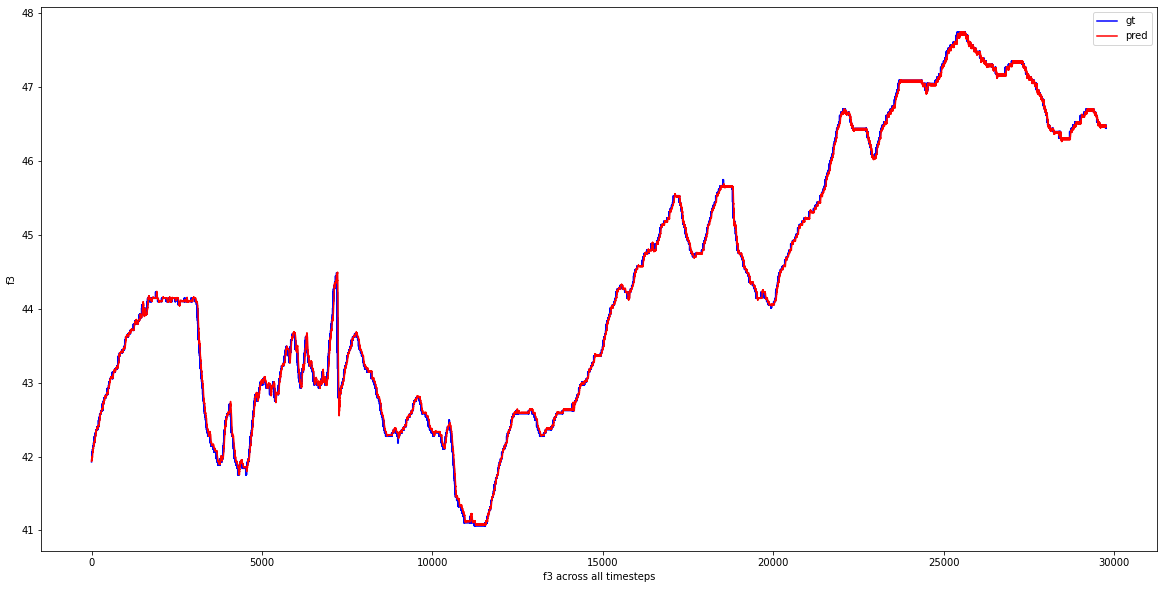

0.0527141161855481


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,2], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,2],c='red', label="pred")

plt.legend()

plt.xlabel('f3 across all timesteps')

plt.ylabel('f3')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,2], pred.reshape(-1,pred.shape[-1])[:,2],squared=False))

Total rmse f4

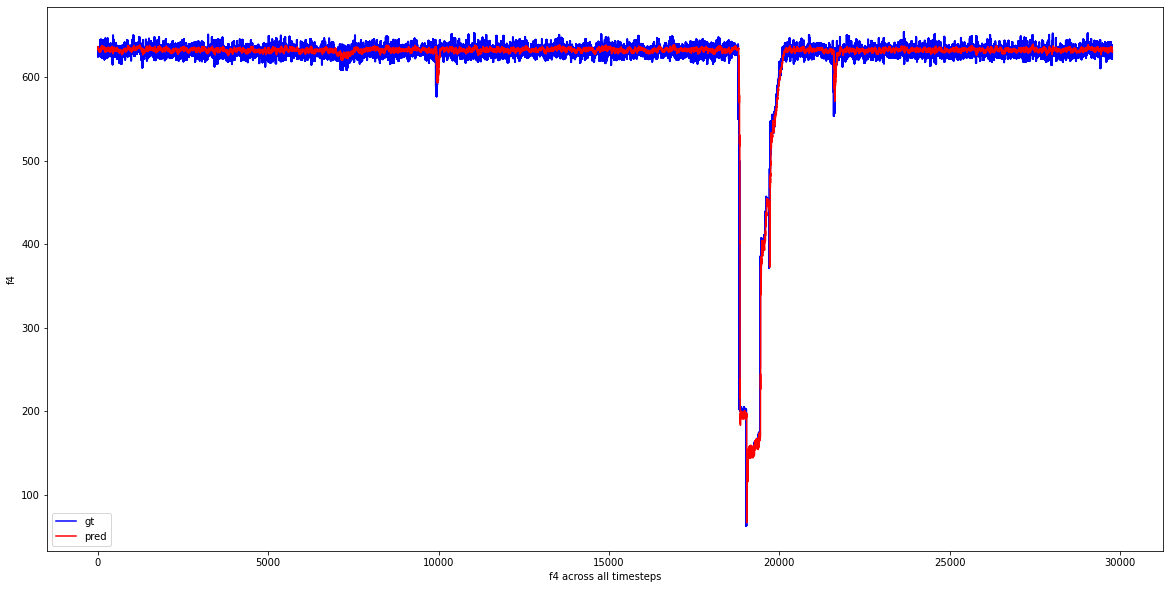

12.036423464675911


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,3], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,3],c='red', label="pred")

plt.legend()

plt.xlabel('f4 across all timesteps')

plt.ylabel('f4')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,3], pred.reshape(-1,pred.shape[-1])[:,3],squared=False))

Total rmse f5

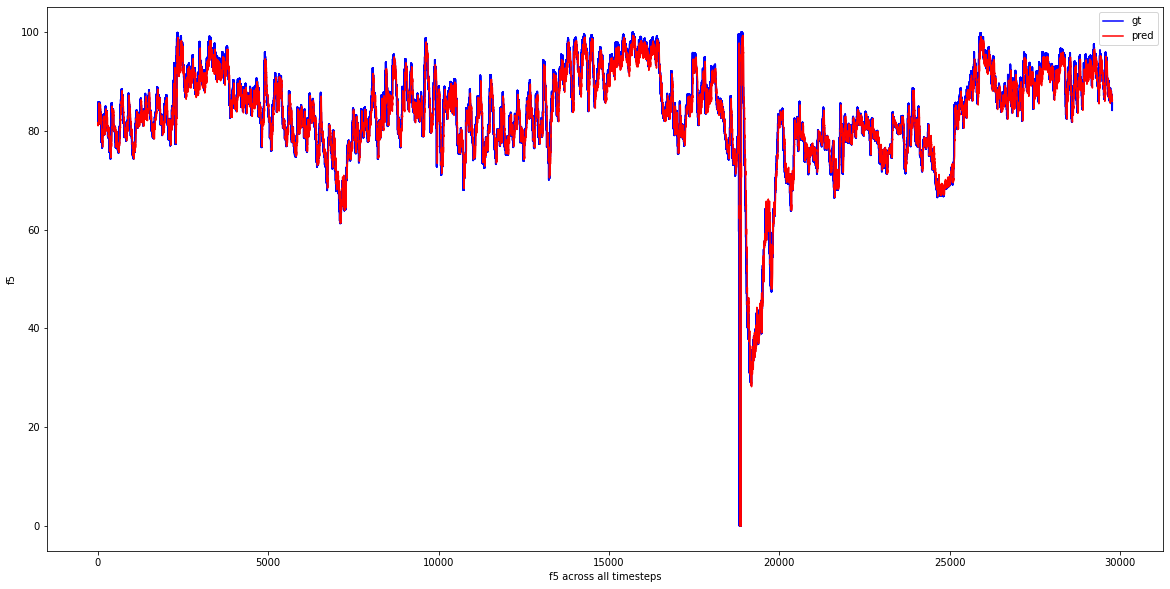

3.7855605825892424


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,4], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,4],c='red', label="pred")

plt.legend()

plt.xlabel('f5 across all timesteps')

plt.ylabel('f5')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,4], pred.reshape(-1,pred.shape[-1])[:,4],squared=False))

Total rmse f6

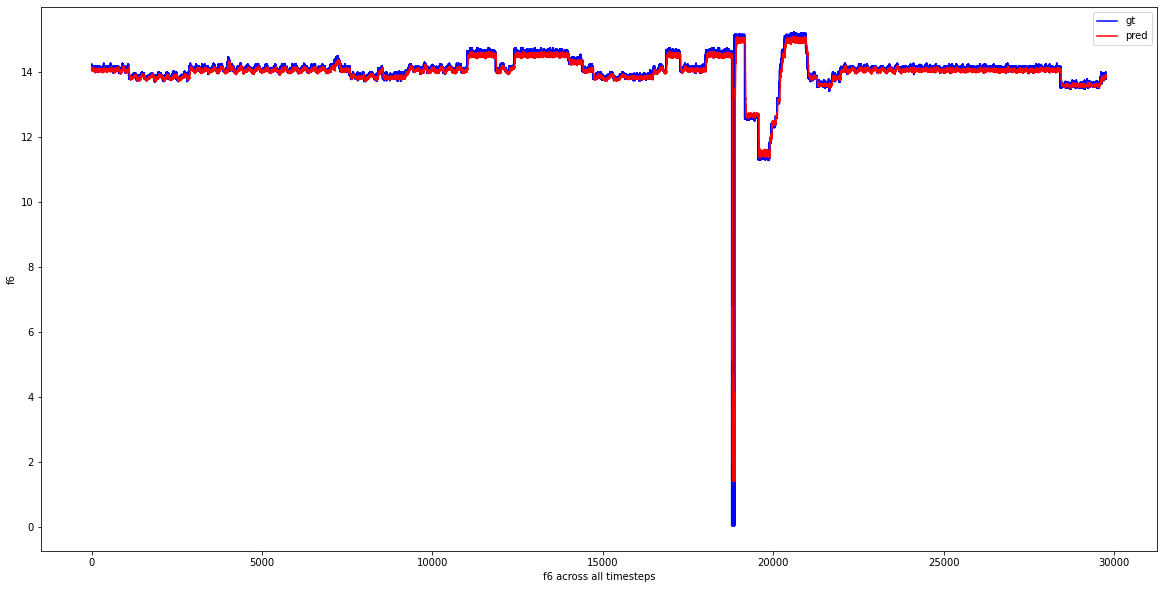

0.45968711351536473


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,5], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,5],c='red', label="pred")

plt.legend()

plt.xlabel('f6 across all timesteps')

plt.ylabel('f6')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,5], pred.reshape(-1,pred.shape[-1])[:,5],squared=False))

Total rmse f7

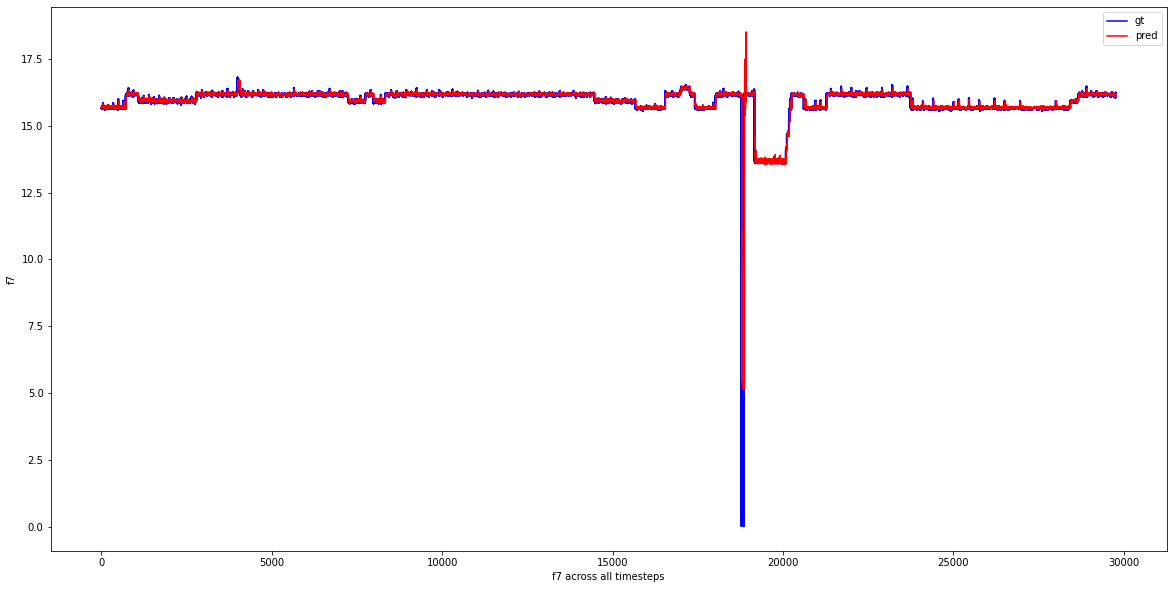

0.5610654033745679


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,6], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,6],c='red', label="pred")

plt.legend()

plt.xlabel('f7 across all timesteps')

plt.ylabel('f7')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,6], pred.reshape(-1,pred.shape[-1])[:,6],squared=False))

Total rmse f8

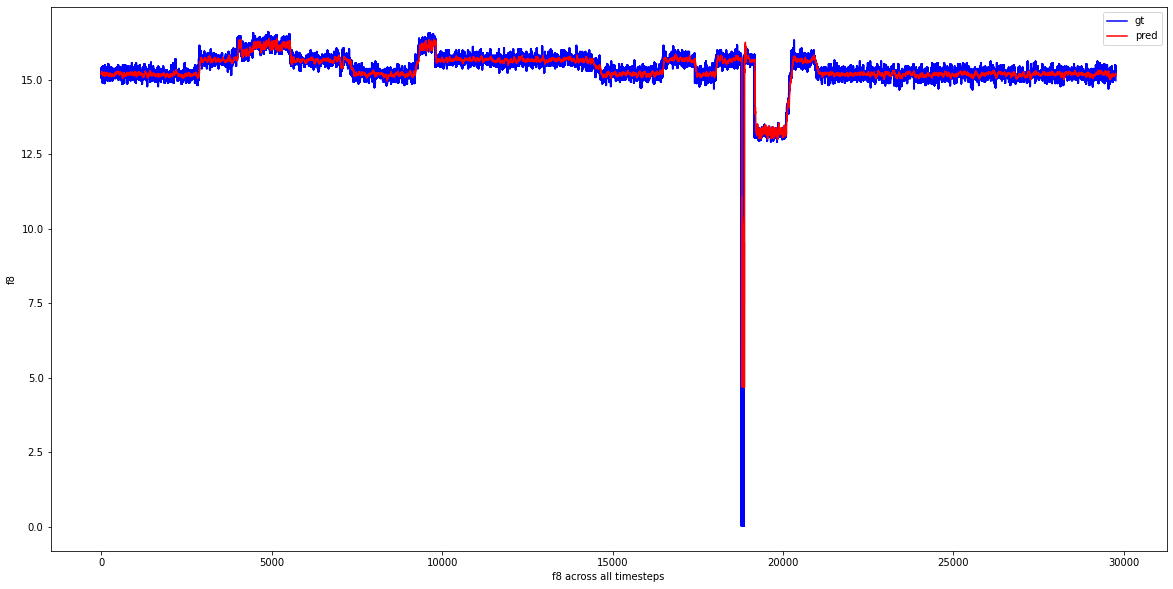

0.5849098456052068


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,7], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,7],c='red', label="pred")

plt.legend()

plt.xlabel('f8 across all timesteps')

plt.ylabel('f8')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,7], pred.reshape(-1,pred.shape[-1])[:,7],squared=False))

Total rmse f9

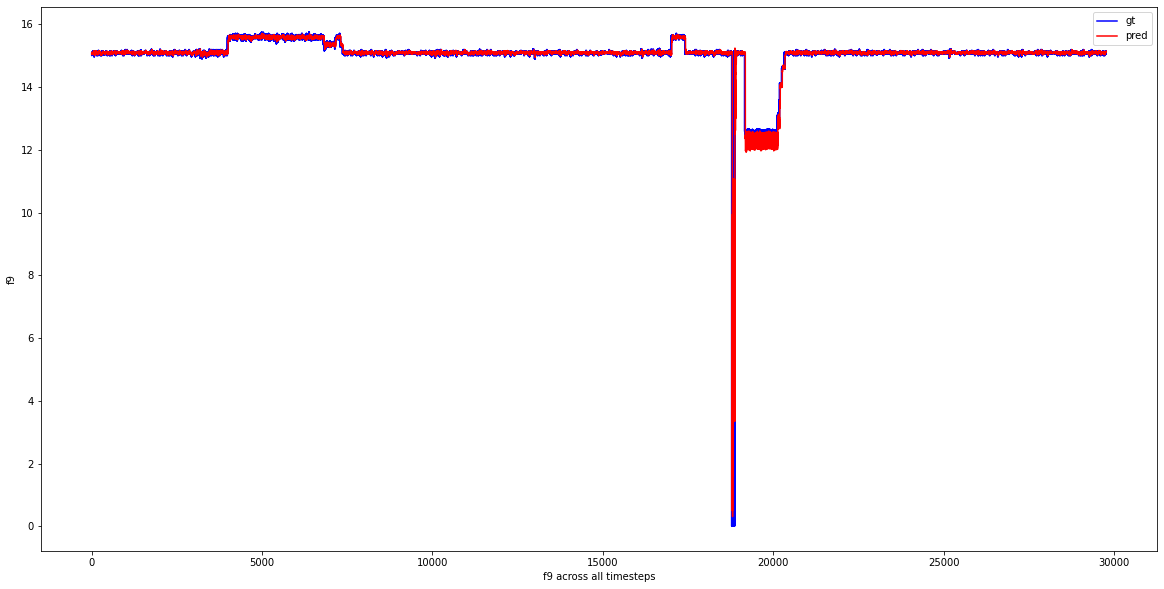

0.5246055847191703


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,8], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,8],c='red', label="pred")

plt.legend()

plt.xlabel('f9 across all timesteps')

plt.ylabel('f9')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,8], pred.reshape(-1,pred.shape[-1])[:,8],squared=False))

Total rmse f10

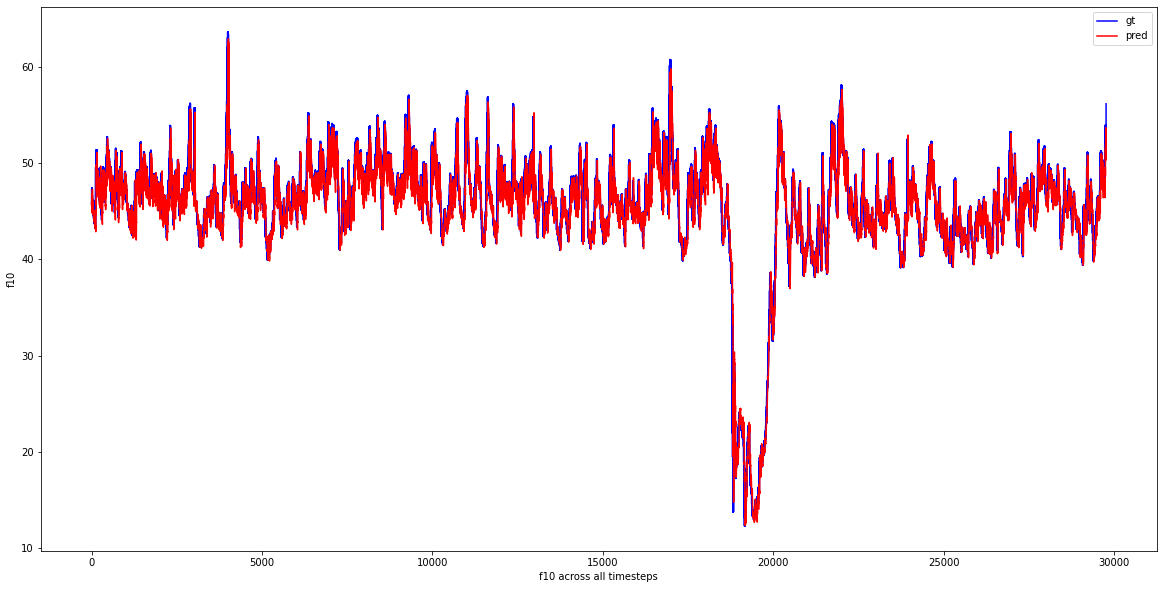

1.722353126006599


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,9], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,9],c='red', label="pred")

plt.legend()

plt.xlabel('f10 across all timesteps')

plt.ylabel('f10')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,9], pred.reshape(-1,pred.shape[-1])[:,9],squared=False))

Total rmse f11

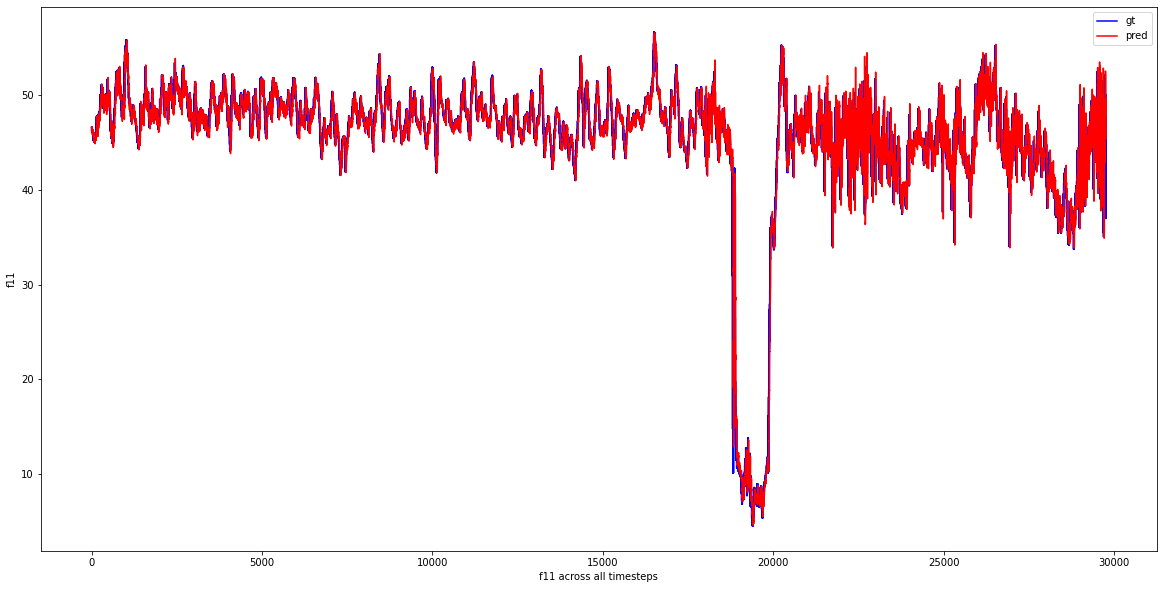

1.981598794570512


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,10], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,10],c='red', label="pred")

plt.legend()

plt.xlabel('f11 across all timesteps')

plt.ylabel('f11')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,10], pred.reshape(-1,pred.shape[-1])[:,10],squared=False))

Total rmse f12

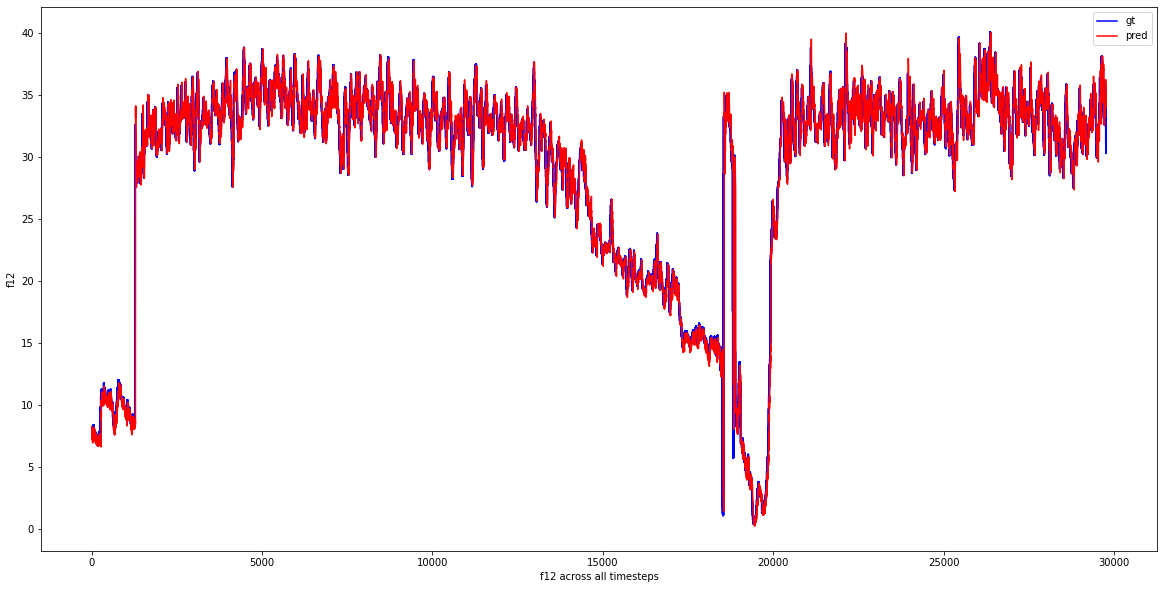

1.5521812341106371


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,11], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,11],c='red', label="pred")

plt.legend()

plt.xlabel('f12 across all timesteps')

plt.ylabel('f12')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,11], pred.reshape(-1,pred.shape[-1])[:,11],squared=False))

Total rmse f13

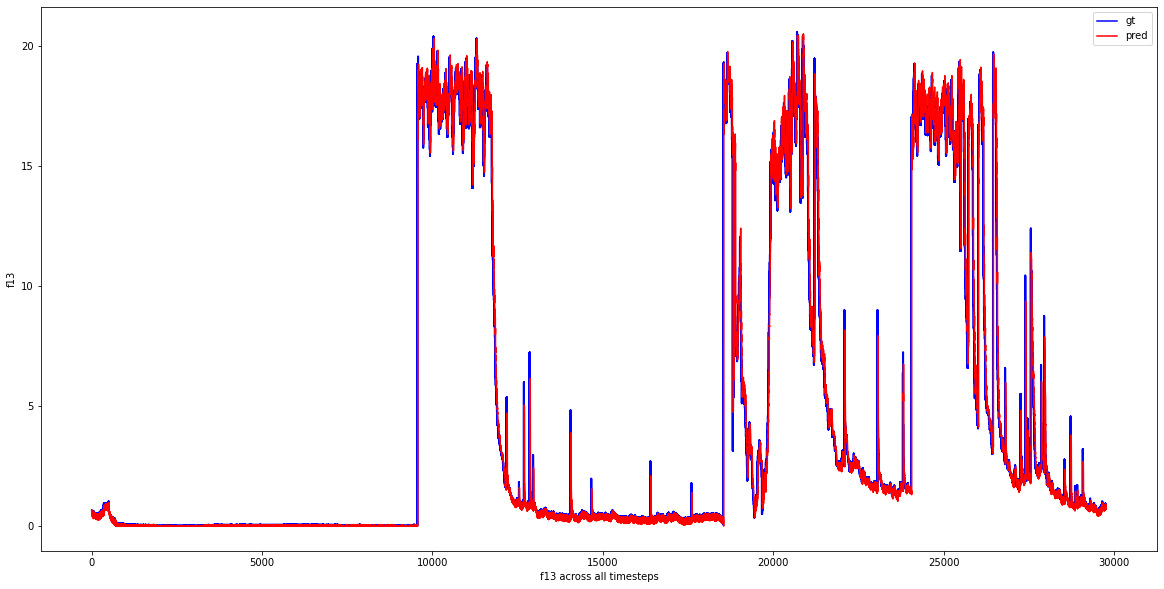

1.2219118271856344


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,12], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,12],c='red', label="pred")

plt.legend()

plt.xlabel('f13 across all timesteps')

plt.ylabel('f13')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,12], pred.reshape(-1,pred.shape[-1])[:,12],squared=False))

Total rmse f14

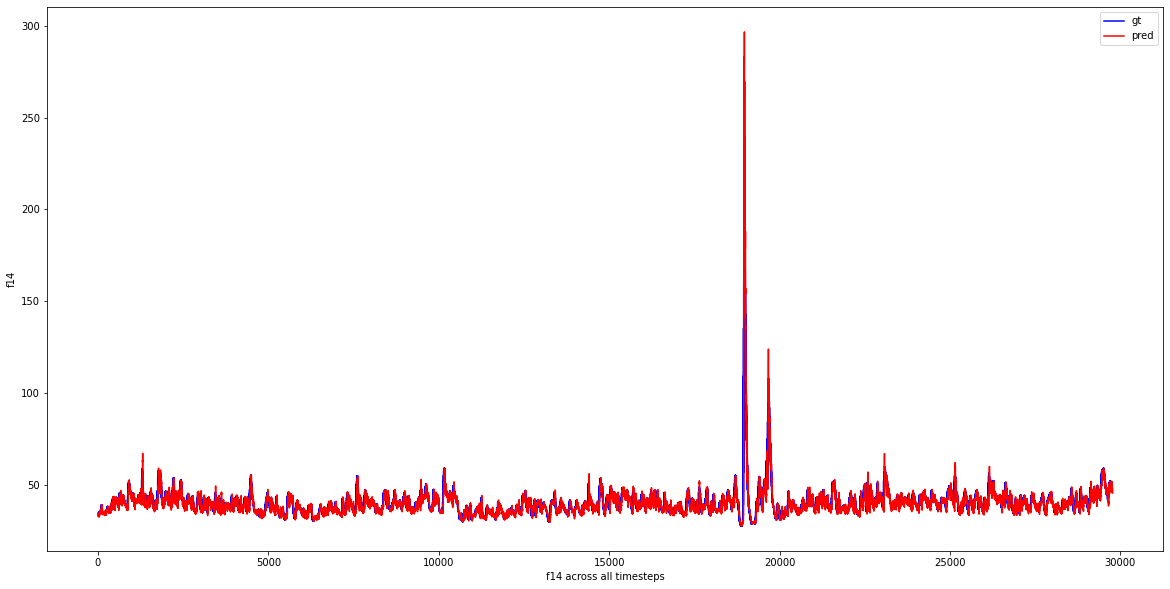

3.477395769438913


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,13], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,13],c='red', label="pred")

plt.legend()

plt.xlabel('f14 across all timesteps')

plt.ylabel('f14')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,13], pred.reshape(-1,pred.shape[-1])[:,13],squared=False))

Total rmse f15

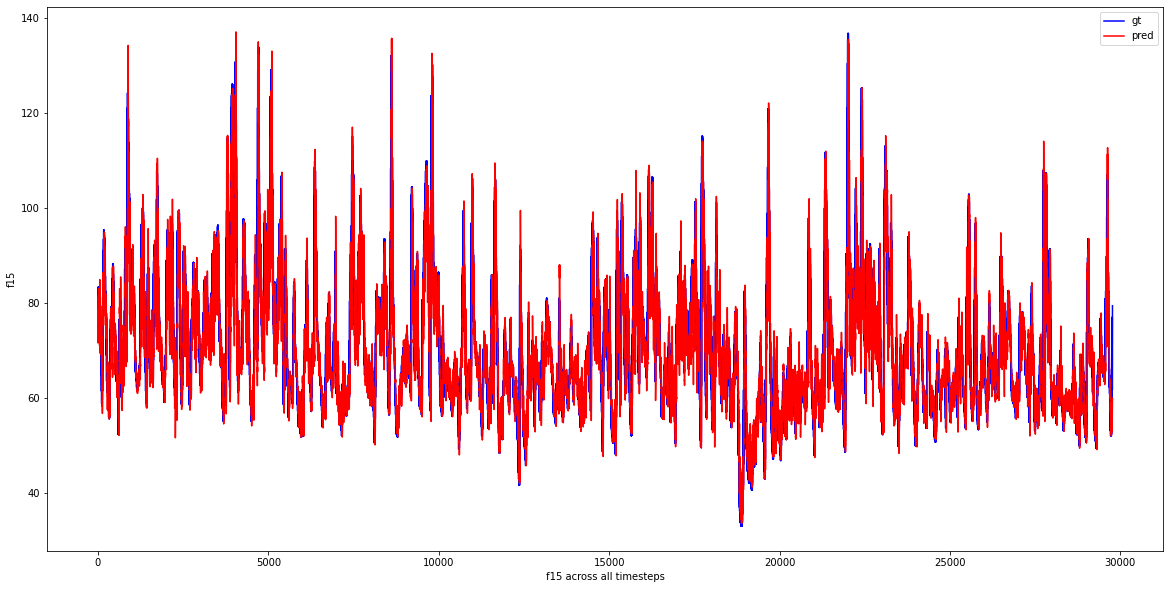

6.516106554821922


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,14], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,14],c='red', label="pred")

plt.legend()

plt.xlabel('f15 across all timesteps')

plt.ylabel('f15')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,14], pred.reshape(-1,pred.shape[-1])[:,14],squared=False))

Total rmse f16

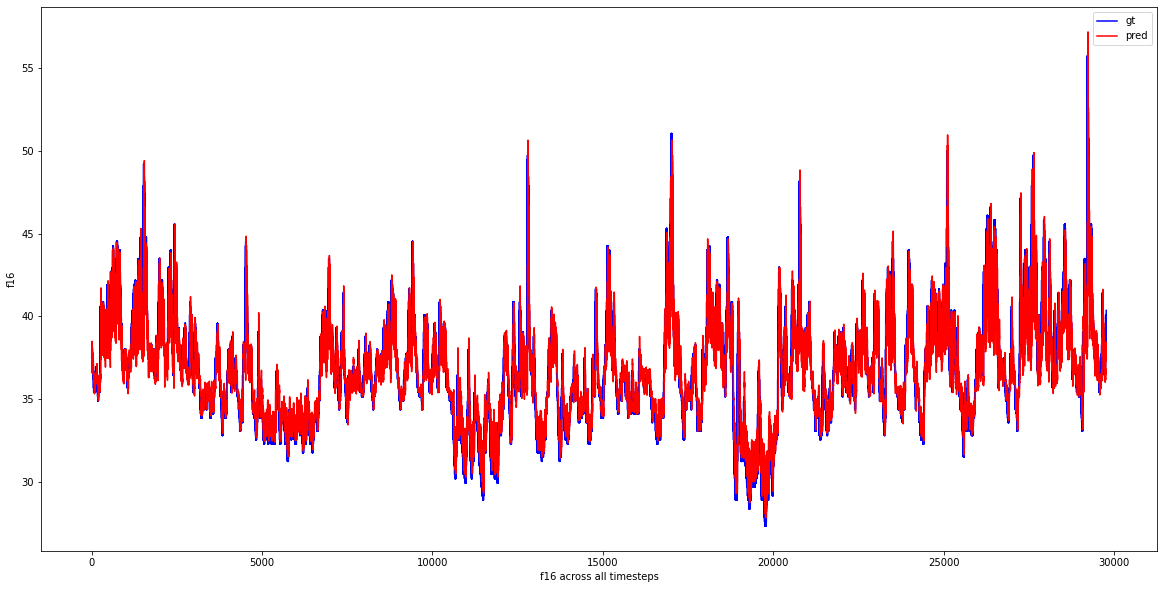

1.4274587918707746


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,15], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,15],c='red', label="pred")

plt.legend()

plt.xlabel('f16 across all timesteps')

plt.ylabel('f16')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,15], pred.reshape(-1,pred.shape[-1])[:,15],squared=False))

Total rmse f17

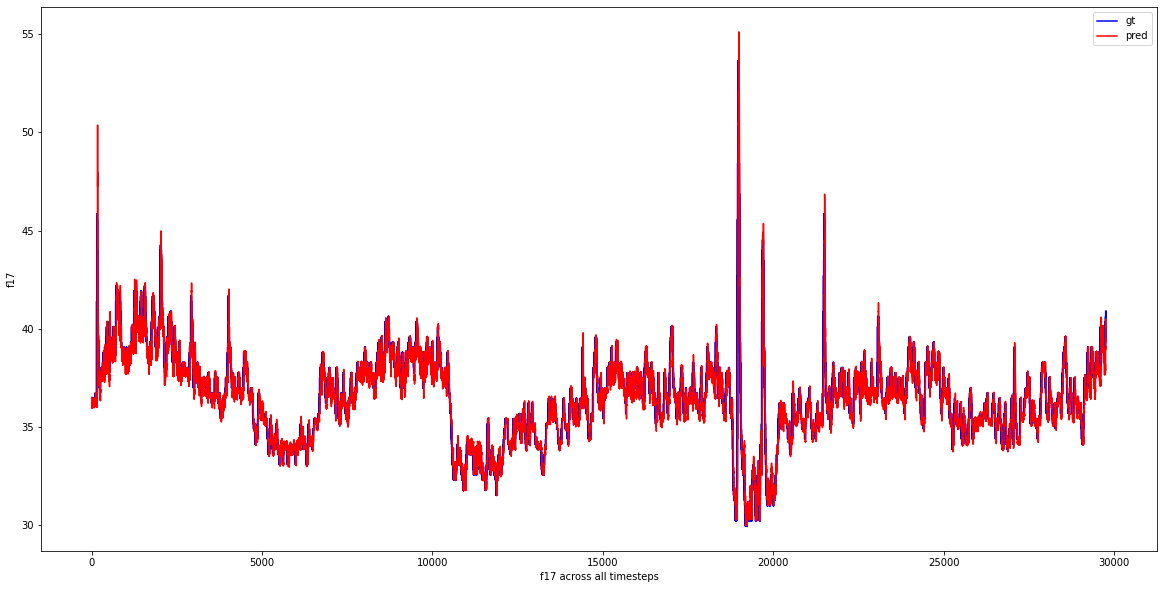

0.7534760671858876


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,16], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,16],c='red', label="pred")

plt.legend()

plt.xlabel('f17 across all timesteps')

plt.ylabel('f17')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,16], pred.reshape(-1,pred.shape[-1])[:,16],squared=False))

Total rmse f18

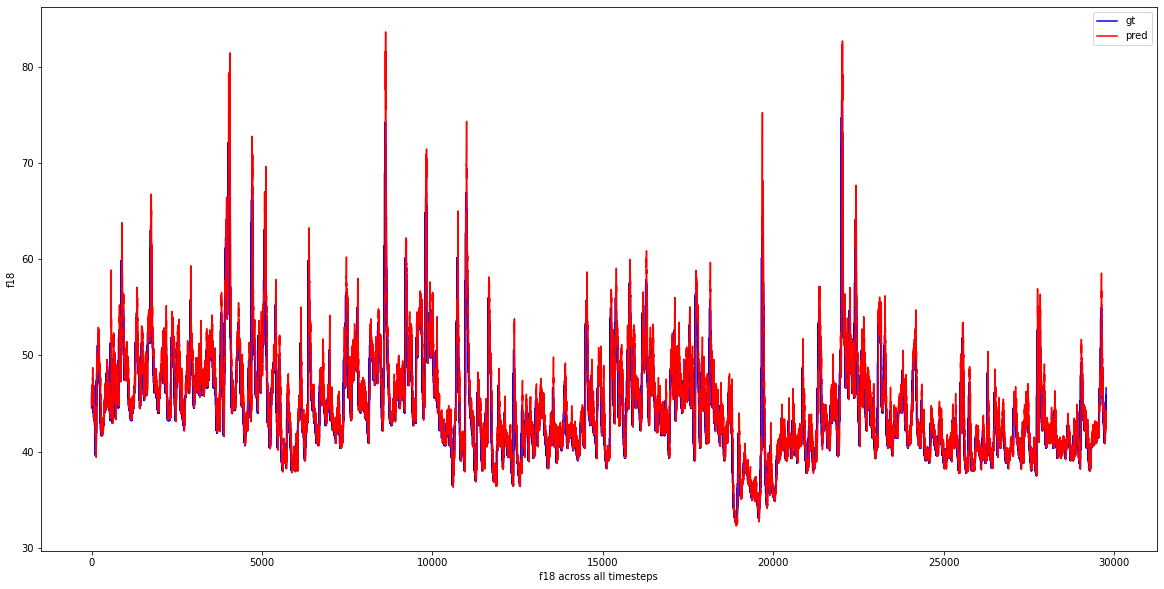

2.4554981291167883


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,17], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,17],c='red', label="pred")

plt.legend()

plt.xlabel('f18 across all timesteps')

plt.ylabel('f18')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,17], pred.reshape(-1,pred.shape[-1])[:,17],squared=False))

Total rmse f19

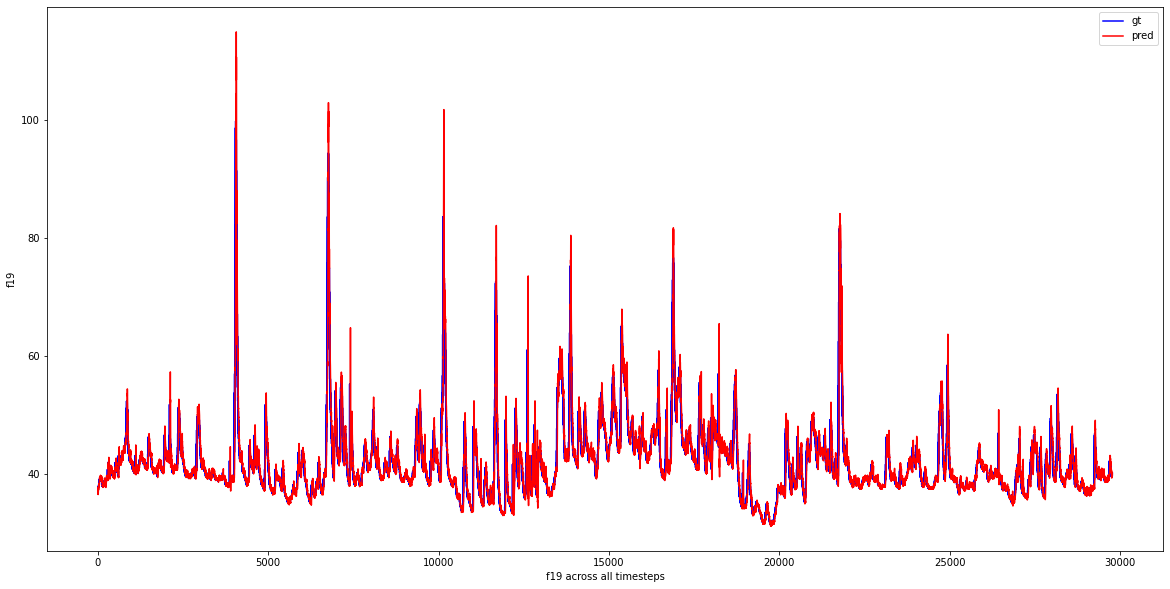

2.3135854729447933


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,18], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,18],c='red', label="pred")

plt.legend()

plt.xlabel('f19 across all timesteps')

plt.ylabel('f19')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,18], pred.reshape(-1,pred.shape[-1])[:,18],squared=False))

Total rmse f20

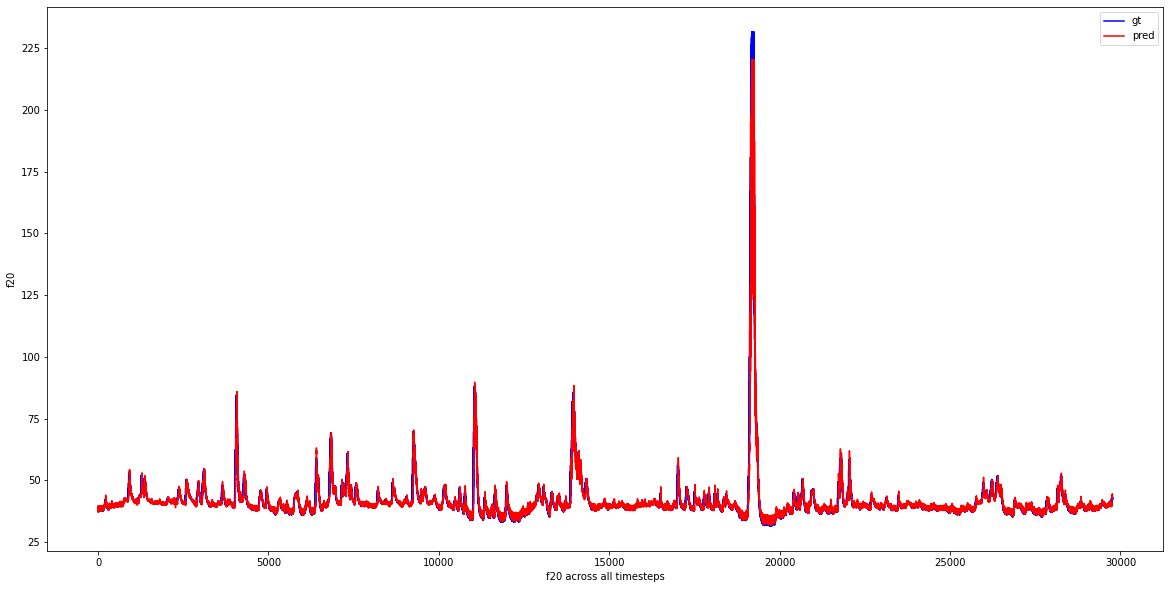

4.224059247093789


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,19], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,19],c='red', label="pred")

plt.legend()

plt.xlabel('f20 across all timesteps')

plt.ylabel('f20')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,19], pred.reshape(-1,pred.shape[-1])[:,19],squared=False))

Total rmse f21

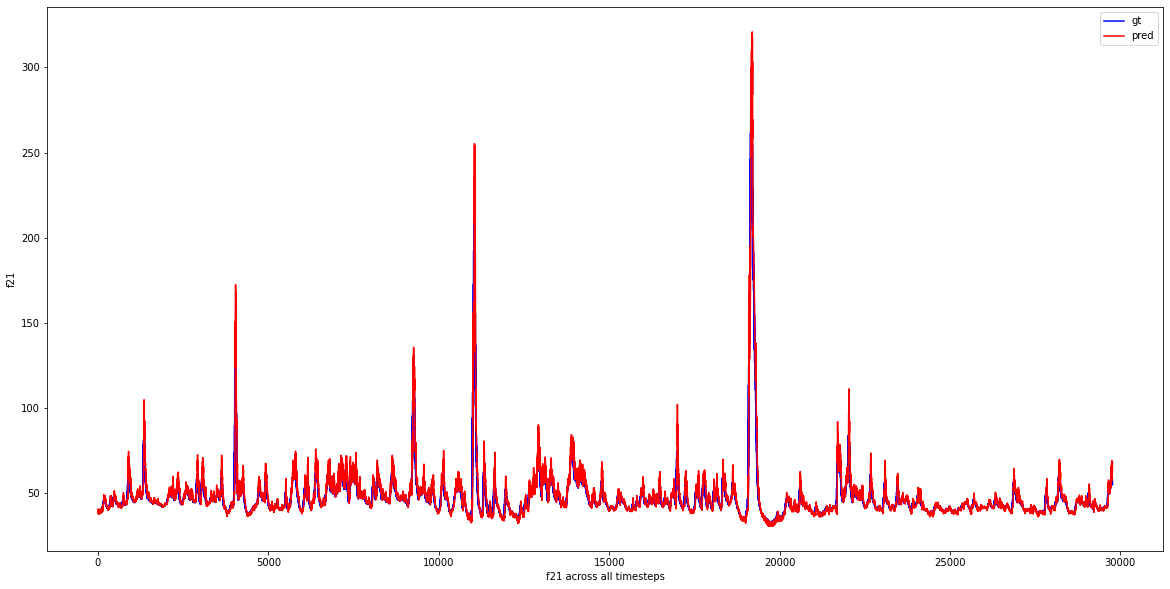

4.725275344660059


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,20], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,20],c='red', label="pred")

plt.legend()

plt.xlabel('f21 across all timesteps')

plt.ylabel('f21')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,20], pred.reshape(-1,pred.shape[-1])[:,20],squared=False))

Total rmse f22

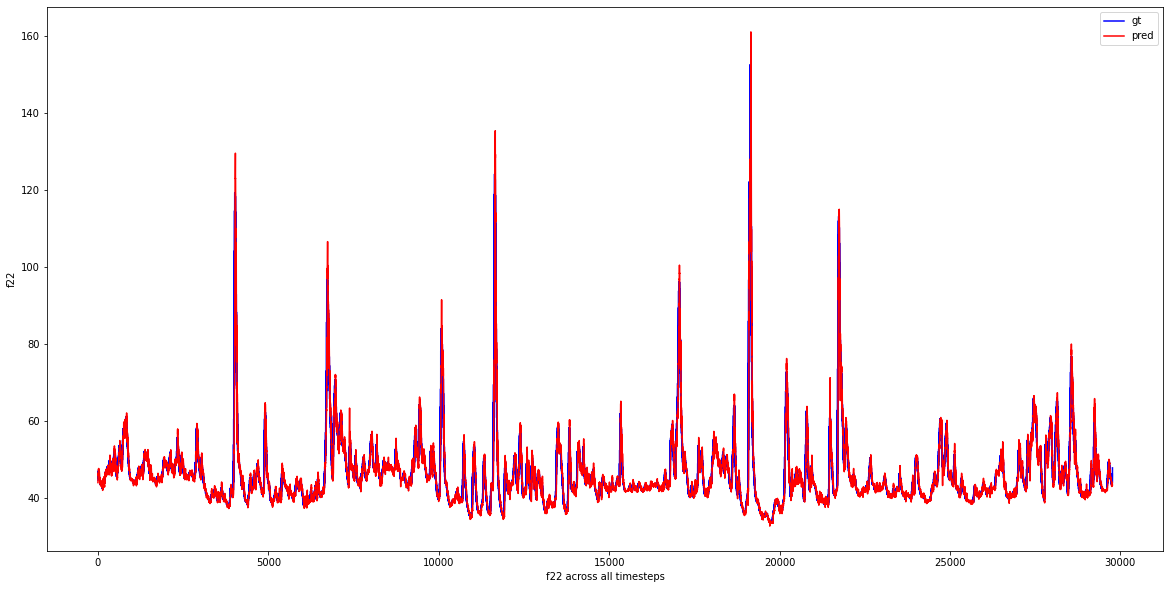

2.637743218562949


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,21], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,21],c='red', label="pred")

plt.legend()

plt.xlabel('f22 across all timesteps')

plt.ylabel('f22')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,21], pred.reshape(-1,pred.shape[-1])[:,21],squared=False))

Total rmse f23

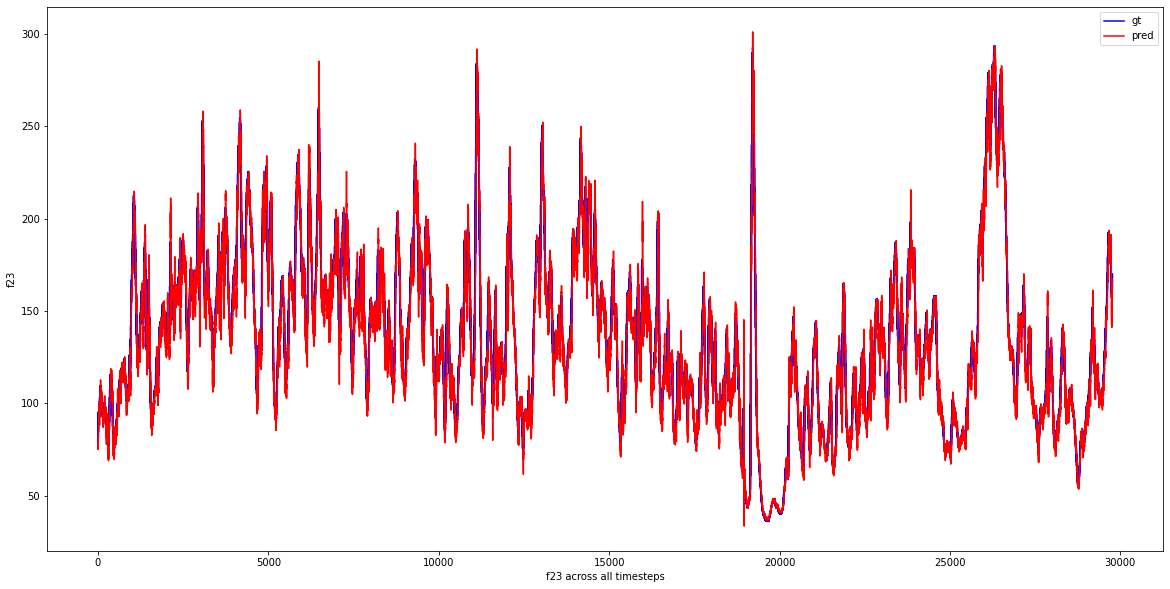

9.099588188182441


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,22], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,22],c='red', label="pred")

plt.legend()

plt.xlabel('f23 across all timesteps')

plt.ylabel('f23')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,22], pred.reshape(-1,pred.shape[-1])[:,22],squared=False))

Total rmse f24

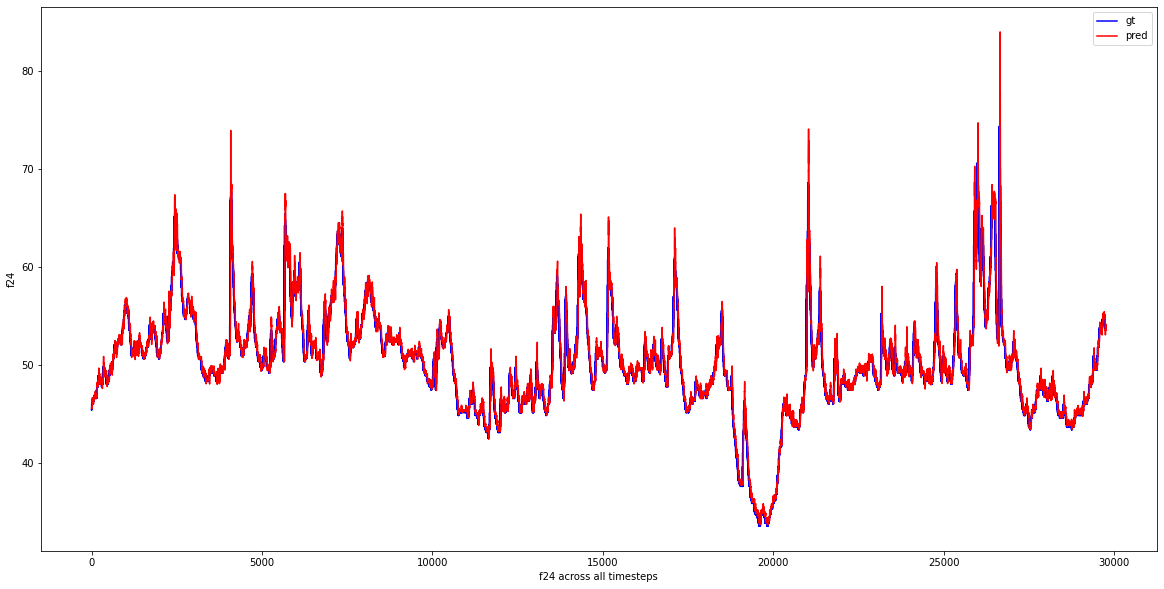

1.0247109782667383


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,23], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,23],c='red', label="pred")

plt.legend()

plt.xlabel('f24 across all timesteps')

plt.ylabel('f24')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,23], pred.reshape(-1,pred.shape[-1])[:,23],squared=False))